<img src="../images/1D_burger.png" width="35%">

In [3]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 

import torch
import torch.nn as nn

## Define the PINN network

In [4]:
class pinn_model(nn.Module):
    def __init__(self):
        super(pinn_model, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out

## Data and Training

In [5]:
class Net:
    def __init__(self):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        # create model pinn
        self.model = pinn_model().to(device)

        # creating of computational domain (collocation points)
        self.h = 0.1  # step size of x
        self.k = 0.1  # step size of t
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T  # collocation points

        # creating of train data points (BC, IC)
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T  # (x=-1, t)
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T  # (x=1, t)
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T  # (x, t=0)
        self.X_train = torch.cat([bc1, bc2, ic])  # concat by row

        # Creating values ​​for training data (BC, IC)
        y_bc1 = torch.zeros(len(bc1))  # u(x=-1, t) = 0
        y_bc2 = torch.zeros(len(bc2))  # u(x=1, t) = 0
        y_ic = -torch.sin(math.pi * ic[:, 0])  # take only x from ic[:, 0] 0 column means x
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic]) # answers for X_train
        self.y_train = self.y_train.unsqueeze(1)

        # moving all data to device
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True  # for collocation points

        # setting optimizers 
        self.adam = torch.optim.Adam(self.model.parameters())
        # limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr = 1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50, 
            tolerance_grad = 1e-7, 
            tolerance_change = 1.0*np.finfo(float).eps,
            line_search_fn = 'strong_wolfe'
        )
        
        # define loss function
        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    # calculating loss
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        u = self.model(self.X)
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]  # du_dX shape equal to (231, 2) because self.X has two components (x, t)


        du_dx = du_dX[:, 0]  # du_dx.shape = (231, ) because we retrieve
        du_dt = du_dX[:, 1]  # du_dt.shape = (231, ) because we retrieve

        du_dXX =torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs=torch.ones_like(du_dX),
            create_graph=True,
            retain_graph=True
        )[0]  
            # The torch.autograd.grad function returns a tuple of gradients, 
            # since you can query gradients across multiple input tensors at once. 
            # In your case, you are asking for gradients on only one input tensor (self.X), 
            # so the function returns a tuple with one element. 
            # Therefore, to get the gradient tensor itself, you need to use [0]


        du_dxx = du_dXX[:, 0]
        
        v_diffusion = 0.01 / math.pi 
        pde_residual = du_dt + u.squeeze() * du_dx - v_diffusion * du_dxx 

        loss_pde = self.criterion(pde_residual, torch.zeros_like(pde_residual))

        loss = loss_data + loss_pde 
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1

        return loss 
    
    # train func
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval() 

In [6]:
# training
net = Net()
net.train()

c:\Users\Yerzhan\python_projects\env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.16295559704303741
200 0.08734689652919769
300 0.07786395400762558
400 0.06642607599496841
500 0.051007241010665894
600 0.028985004872083664
700 0.019960401579737663
800 0.015163145959377289
900 0.02153201960027218
1000 0.010608169250190258
1100 0.006049496121704578
1200 0.0028025000356137753
1300 0.0012353911297395825
1400 0.0007925219251774251
1500 0.0005999723798595369
1600 0.0004966955748386681
1700 0.0003532736445777118
1800 0.0002908467431552708
1900 0.00025060842745006084
2000 0.00021769458544440567
2100 0.00018810269830282778
2200 0.00016738203703425825
2300 0.00014066023868508637
2400 0.000122416066005826
2500 0.00011166519834659994
2600 0.00010066578397527337
2700 9.24518535612151e-05
2800 8.437578071607277e-05
2900 7.520477811340243e-05
3000 6.842660513939336e-05
3100 6.361096893670037e-05
3200 5.7148165069520473e-05
3300 5.509434413397685e-05
3400 5.1118346164003015e-05
3500 4.747514321934432e-05
3600 4.4838197936769575e-05


In [8]:
net.model.eval()

pinn_model(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

## Results evaluation (visualization)

In [11]:
h = 0.01
k = 0.01

x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)


In [14]:
x.shape, t.shape

(torch.Size([200]), torch.Size([100]))

In [12]:
X

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]], device='cuda:0')

In [13]:
X.shape

torch.Size([20000, 2])

In [15]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)  # y_pred shape(20000, 1)
    y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()  # reshaped to (200, 100)

In [17]:
y_pred.shape

(200, 100)

In [18]:
y_pred

array([[ 0.0023208 ,  0.00180297,  0.00135012, ..., -0.00209942,
        -0.00209879, -0.00209805],
       [ 0.03537616,  0.03381398,  0.0323717 , ...,  0.00559755,
         0.00553725,  0.00547872],
       [ 0.06804095,  0.06546822,  0.06306772, ...,  0.01330616,
         0.01318559,  0.01306712],
       ...,
       [-0.0961362 , -0.0933979 , -0.09084253, ..., -0.02436621,
        -0.02419002, -0.02402149],
       [-0.06370591, -0.06193532, -0.06029816, ..., -0.01644076,
        -0.01632448, -0.01621558],
       [-0.03089122, -0.03011273, -0.02941777, ..., -0.00851436,
        -0.00845824, -0.00840862]], dtype=float32)

Text(103.66666666666667, 0.5, 'x')

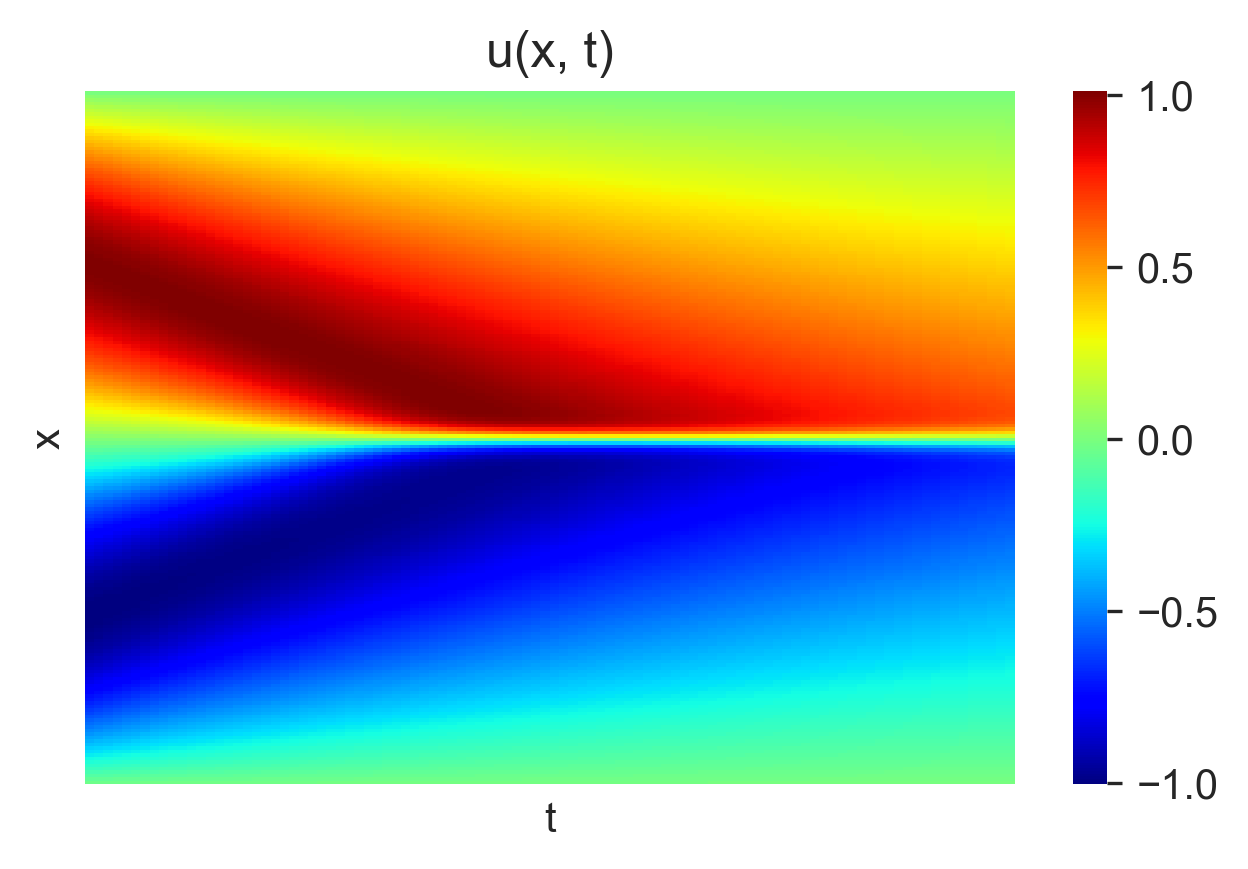

In [58]:
sns.set_style('white')
plt.figure(figsize=(5, 3), dpi=300)
plt.title('u(x, t)')
sns.heatmap(y_pred, cmap='jet')
plt.xticks([])
plt.yticks([])
plt.xlabel('t')
plt.ylabel('x')

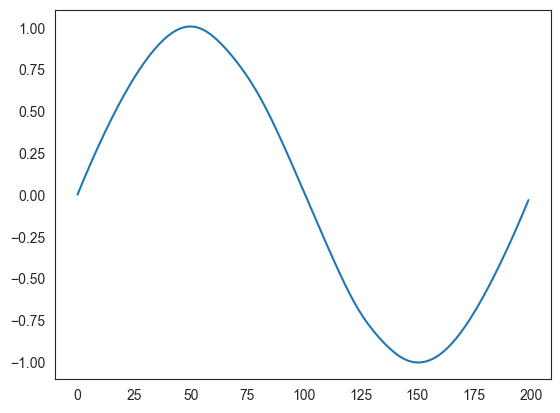

In [20]:
plt.plot(y_pred[:, 0])  # starting step of t

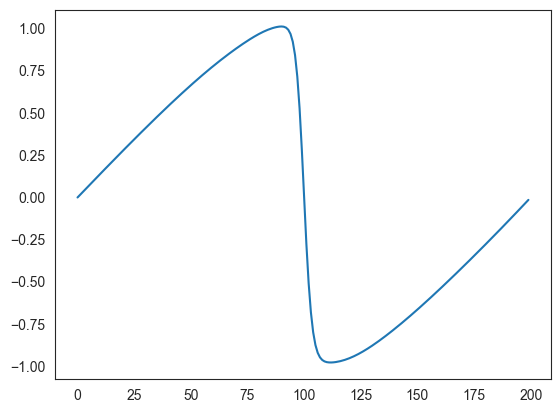

In [23]:
plt.plot(y_pred[:, 50])  # middle step of t

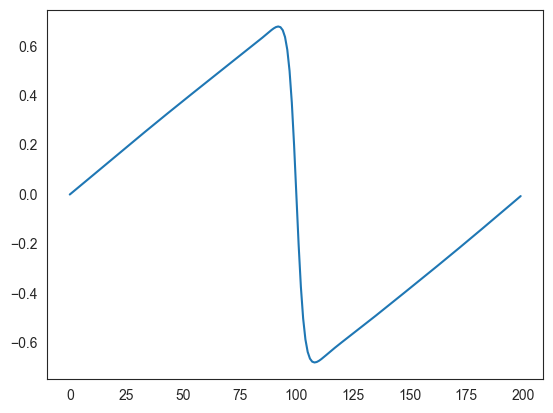

In [26]:
plt.plot(y_pred[:, 99])  # last step of t

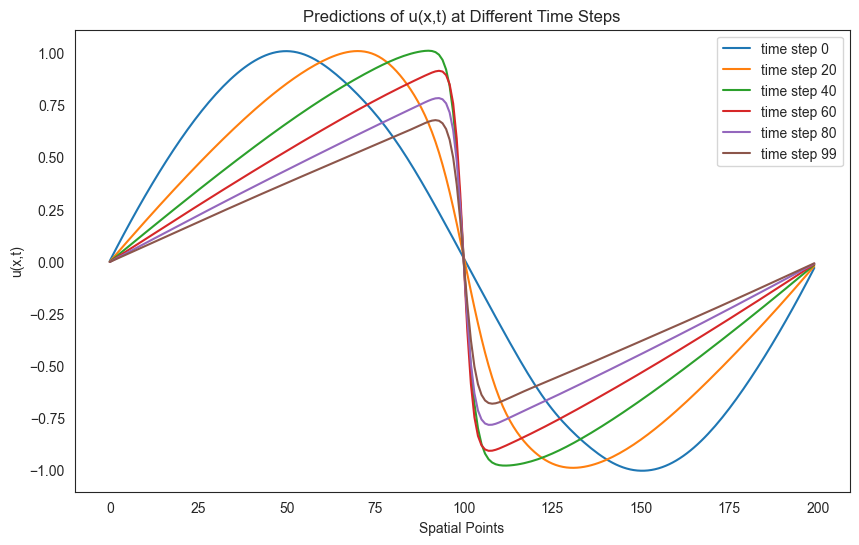

In [28]:
# Plot the prediction at different time steps
time_steps = [0, 20, 40, 60, 80, 99]  # You can change these to other time steps you are interested in
plt.figure(figsize=(10, 6))

for t in time_steps:
    plt.plot(y_pred[:, t], label=f'time step {t}')

plt.xlabel('Spatial Points')
plt.ylabel('u(x,t)')
plt.title('Predictions of u(x,t) at Different Time Steps')
plt.legend()
plt.show()

In [46]:
# %matplotlib notebook
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.animation import FuncAnimation

# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 100  
# plt.rcParams['animation.embed_limit'] = 50.0  # Set the limit to 50 MB
# plt.ioff()
# # Assume y_pred is your prediction array with shape (200, 100)
# # The first axis (200) represents spatial points and the second axis (100) represents time steps.

# fig, ax = plt.subplots()
# line, = ax.plot(y_pred[:, 0], color='red', linestyle='--')
# ax.set_xlim(0, y_pred.shape[0])
# ax.set_ylim(np.min(y_pred), np.max(y_pred))
# ax.set_xlabel('x')
# ax.set_ylabel('u(x,t)')
# ax.set_title('PINN Prediction of u(x,t)')

# def update(frame):
#     line.set_ydata(y_pred[:, frame])
#     ax.set_title(f'PINN Prediction of u(x,t) at Time Step {frame}')
#     return line

# ani = FuncAnimation(fig, update, frames=range(y_pred.shape[1]), interval=40, blit=True)
# ani 

In [47]:
# ani.save('PINN_1D_burger_animation.gif', writer='pillow', fps=50)

In [16]:
# TEST

# x_test = torch.arange(-1, 1 + 0.1, 0.1)
# t_test = torch.arange(0, 1 + 0.1, 0.1)
# print(x_test)
# print(t_test)

# X_test = torch.stack(torch.meshgrid(x_test, t_test)).reshape(2, -1).T
# print(X_test, X_test.shape)

# test = X_test[:, 0]
# print(test.shape)

# bc1_test = torch.stack(torch.meshgrid(x_test[0], t_test)).reshape(2, -1).T 
# bc2_test = torch.stack(torch.meshgrid(x_test[-1], t_test)).reshape(2, -1).T 
# ic_test = torch.stack(torch.meshgrid(x_test, t_test[0])).reshape(2, -1).T 

# print(len(bc1_test))
# print(bc1_test, bc1_test.shape)
# print(bc2_test, bc2_test.shape)
# print(ic_test, ic_test.shape)

# x_concat  = torch.cat([bc1_test, bc2_test])
# print(x_concat.shape)

# y_train_test = torch.tensor([1, 2, 3, 4])
# print(y_train_test, y_train_test.shape)
# y_train_test = y_train_test.unsqueeze(1)
# print(y_train_test, y_train_test.shape)